In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
!pip install gradio

In [41]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=30

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset/",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 7395 files belonging to 2 classes.


In [5]:
class_names = dataset.class_names
class_names

['glass', 'table']

In [6]:
from struct import unpack
from tqdm import tqdm
import os


marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}


class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
                raise TypeError("issue reading jpeg file")            


bads = []
img_dir = "dataset/glass/"
root_img = ("dataset/glass/glass")

for dirName, subdirList, fileList in os.walk(img_dir):
    imagesList = fileList
    for img in tqdm(imagesList):
      image = os.path.join(root_img,img)
      image = JPEG(image) 
      try:
        image.decode()   
      except:
        bads.append(img)


for name in bads:
  os.remove(os.path.join(root_img,name))

0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████| 3787/3787 [00:02<00:00, 1478.01it/s]


In [7]:
from struct import unpack
from tqdm import tqdm
import os


marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}


class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
                raise TypeError("issue reading jpeg file")            


bads = []
img_dir = "dataset/table/"
root_img = ("dataset/table/table")

for dirName, subdirList, fileList in os.walk(img_dir):
    imagesList = fileList
    for img in tqdm(imagesList):
      image = os.path.join(root_img,img)
      image = JPEG(image) 
      try:
        image.decode()   
      except:
        bads.append(img)


for name in bads:
  os.remove(os.path.join(root_img,name))

0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████| 3608/3608 [00:02<00:00, 1382.84it/s]


In [8]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 0 0 0 1 1 1 1 1 1 0 0 0 1 1 0 1 1 1 0 0 0 0 0 1 1 0 1 1 1 0 0]


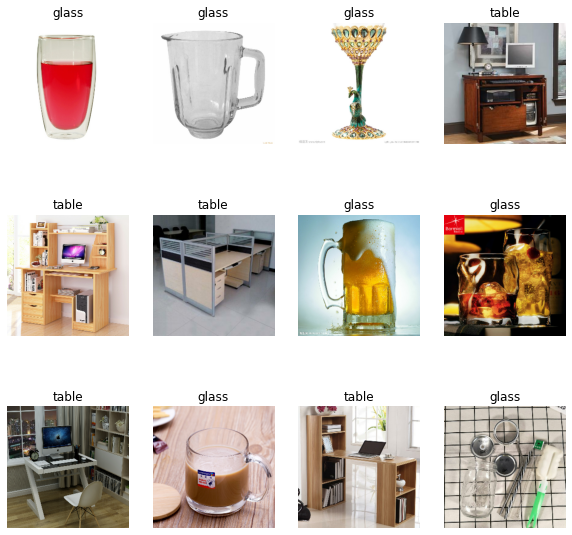

In [9]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [10]:
len(dataset)

232

In [11]:
train_size = 0.8
len(dataset)*train_size

185.60000000000002

In [12]:
train_ds = dataset.take(54)
len(train_ds)

54

In [13]:
test_ds = dataset.skip(54)
len(test_ds)

178

In [14]:
val_size=0.1
len(dataset)*val_size

23.200000000000003

In [15]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [16]:
test_ds = test_ds.skip(6)
len(test_ds)

172

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [19]:
len(train_ds)

185

In [20]:
len(val_ds)

23

In [21]:
len(test_ds)

24

In [22]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [24]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [25]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [28]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [29]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30
185/185 [==============================] - 432s 2s/step - loss: 0.6130 - accuracy: 0.6432 - val_loss: 0.4295 - val_accuracy: 0.8193
Epoch 2/30
185/185 [==============================] - 363s 2s/step - loss: 0.3992 - accuracy: 0.8287 - val_loss: 0.3627 - val_accuracy: 0.8329
Epoch 3/30
185/185 [==============================] - 356s 2s/step - loss: 0.3583 - accuracy: 0.8476 - val_loss: 0.2961 - val_accuracy: 0.8709
Epoch 4/30
185/185 [==============================] - 366s 2s/step - loss: 0.3508 - accuracy: 0.8522 - val_loss: 0.3283 - val_accuracy: 0.8560
Epoch 5/30
185/185 [==============================] - 366s 2s/step - loss: 0.3413 - accuracy: 0.8576 - val_loss: 0.2777 - val_accuracy: 0.8750
Epoch 6/30
185/185 [==============================] - 371s 2s/step - loss: 0.3107 - accuracy: 0.8731 - val_loss: 0.2628 - val_accuracy: 0.8899
Epoch 7/30
185/185 [==============================] - 368s 2s/step - loss: 0.2959 - accuracy: 0.8782 - val_loss: 0.2423 - val_accuracy: 0.8927

In [30]:
scores = model.evaluate(test_ds)

24/24 [==============================] - 24s 231ms/step - loss: 0.1332 - accuracy: 0.9486


In [31]:
scores

[0.13322800397872925, 0.9485791325569153]

In [32]:
history

In [33]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 185}

In [34]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [35]:
type(history.history['loss'])

list

In [36]:
len(history.history['loss'])

30

In [38]:
history.history['loss'][:30] # show loss for first 5 epochs

[0.613028347492218,
 0.39915135502815247,
 0.3582839071750641,
 0.3507890999317169,
 0.3413069546222687,
 0.31065887212753296,
 0.29587870836257935,
 0.2692706286907196,
 0.27957993745803833,
 0.2442423403263092,
 0.23388463258743286,
 0.2234412282705307,
 0.20550629496574402,
 0.20227593183517456,
 0.2001027762889862,
 0.19640007615089417,
 0.1890571415424347,
 0.18682046234607697,
 0.17083410918712616,
 0.1785423308610916,
 0.1657051146030426,
 0.1593838930130005,
 0.14855504035949707,
 0.1388617306947708,
 0.14105863869190216,
 0.14369207620620728,
 0.13410215079784393,
 0.13558225333690643,
 0.148067906498909,
 0.12700273096561432]

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

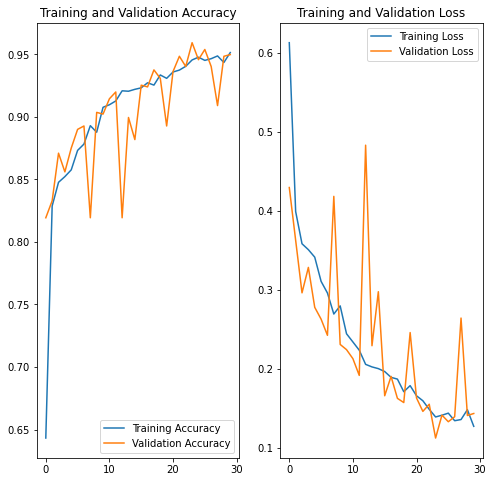

In [42]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: table
1/1 [==============================] - 1s 580ms/step
predicted label: table


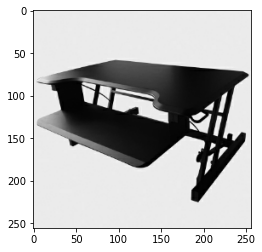

In [43]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[27].numpy().astype('uint8')
    first_label = labels_batch[27].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [44]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 51ms/step


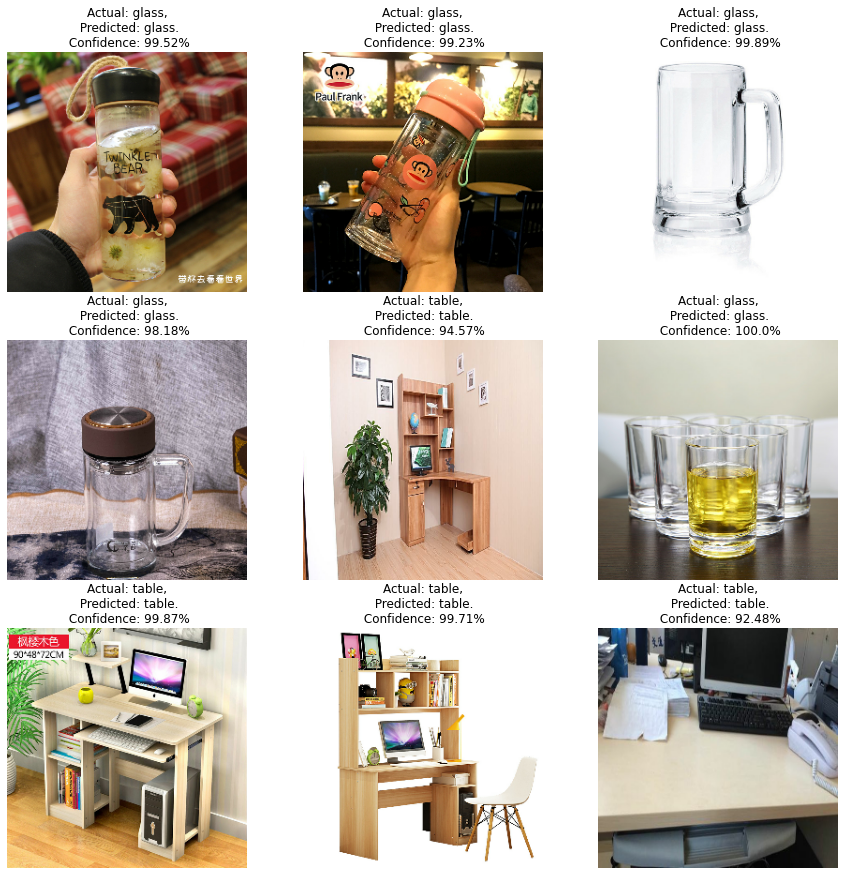

In [45]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [46]:
model.save('./models', save_format='tf')

INFO:tensorflow:Assets written to: ./models\assets


INFO:tensorflow:Assets written to: ./models\assets


In [47]:
import gradio as gr

In [55]:
def predict_image(img):
  img_4d=img.reshape(-1,256,256,3)
  prediction=model.predict(img_4d)[0]
  return {class_names[i]: float(prediction[i]) for i in range(2)}

In [56]:
gr.Interface(fn=predict_image, 
             inputs=gr.Image(shape=(256, 256)),
             outputs=gr.Label(num_top_classes=2),
             interpretation='default').launch(debug='True')


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 43ms/step
Keyboard interruption in main thread... closing server.
